# Detection - **Post-processing**

**Content**

- `clear_outside_frame_range` to remove the background off the track
- `remove_outliers`
- `interpolate_missing_coordinates` with `median_filter` and `Savitzky_Golay_filter`

In [16]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

import pandas as pd
from scipy.signal import medfilt
from scipy.signal import savgol_filter

Auxiliary data and functions

In [17]:
def plot_trajectory(df):
    plt.figure(figsize=(3, 6))
    plt.plot(df["x"], -df["y"], "o-", label="Cleaned Trajectory", markersize=5)
    plt.xlabel("X Coordinate")
    plt.ylabel("Y Coordinate")
    plt.title("Cleaned Ball Trajectory")
    plt.legend()
    plt.show()

In [18]:
def plot_trajectories(raw_df, cleaned_df):
    # Create a figure with two subplots side by side
    fig, axes = plt.subplots(1, 2, figsize=(6, 6))

    # Plot the original (raw) data on the left subplot
    axes[0].plot(raw_df["x"], -raw_df["y"], "o-", label="Trajectory", markersize=5)
    axes[0].set_title("Previous Ball Trajectory")
    axes[0].set_xlabel("X Coordinate")
    axes[0].set_ylabel("Y Coordinate")
    axes[0].legend()

    # Plot the cleaned data on the right subplot
    axes[1].plot(
        cleaned_df["x"], -cleaned_df["y"], "o-", label="Trajectory", markersize=5
    )
    axes[1].set_title("Processed Ball Trajectory")
    axes[1].set_xlabel("X Coordinate")
    axes[1].set_ylabel("Y Coordinate")
    axes[1].legend()

    # Adjust layout for better appearance
    plt.tight_layout()
    plt.show()

In [19]:
def plot_comparison(df, df_cleaned):
    # Create a mask identifying outlier rows (i.e. those with NaN in x or y in the cleaned version)
    outlier_mask = df_cleaned[["x", "y"]].isna().any(axis=1)

    # Create a figure with two side-by-side subplots
    fig, axes = plt.subplots(1, 2, figsize=(6, 6))

    # Plot 1: Original Data with Outliers Highlighted
    # Plot valid points from the original data (non-outliers)
    axes[0].plot(
        df.loc[~outlier_mask, "x"],
        -df.loc[~outlier_mask, "y"],
        "o-",
        label="Valid Points",
        color="blue",
        markersize=5,
    )
    # Overlay the outliers in red
    axes[0].plot(
        df.loc[outlier_mask, "x"],
        -df.loc[outlier_mask, "y"],
        "o",
        label="Outliers",
        color="red",
        markersize=5,
    )
    axes[0].set_xlabel("X Coordinate")
    axes[0].set_ylabel("Y Coordinate")
    axes[0].set_title("Original Points with Outliers Highlighted")
    axes[0].legend()

    # Plot 2: Cleaned Data
    # Plot only the non-NaN points from the cleaned DataFrame (which are the valid ones)
    valid_cleaned = df_cleaned.dropna(subset=["x", "y"])
    axes[1].plot(
        valid_cleaned["x"],
        -valid_cleaned["y"],
        "o-",
        label="Cleaned Trajectory",
        color="green",
        markersize=5,
    )
    axes[1].set_xlabel("X Coordinate")
    axes[1].set_ylabel("Y Coordinate")
    axes[1].set_title("Cleaned Points Only")
    axes[1].legend()

    plt.tight_layout()
    plt.show()

In [20]:
def show_lines_on_frame(row, ax=None):
    bl = np.array([row["bottom_left_x"], row["bottom_left_y"]])
    br = np.array([row["bottom_right_x"], row["bottom_right_y"]])
    ul = np.array([row["up_left_x"], row["up_left_y"]])
    ur = np.array([row["up_right_x"], row["up_right_y"]])

    mid_bottom = (bl + br) / 2
    mid_upper = (ul + ur) / 2
    lifted_mid = mid_bottom + (mid_upper - mid_bottom) / 5

    # Direction vector along bottom line
    dir_vector = br - bl
    dir_vector = dir_vector / np.linalg.norm(dir_vector)

    # Create new lifted line endpoints
    p1 = lifted_mid - 200 * dir_vector
    p2 = lifted_mid + 200 * dir_vector

    # Create plot
    if ax is None:
        fig, ax = plt.subplots(figsize=(6, 4))

    # Plot bottom line
    ax.plot([bl[0], br[0]], [bl[1], br[1]], "b-", label="Bottom Line")

    # Plot up line
    ax.plot([ul[0], ur[0]], [ul[1], ur[1]], "g-", label="Up Line")

    # Plot lifted (new) line
    ax.plot([p1[0], p2[0]], [p1[1], p2[1]], "r--", label="New (Lifted) Line")

    # Optionally plot ball position
    if not np.isnan(row["x"]) and not np.isnan(row["y"]):
        ax.plot(row["x"], row["y"], "ro", label="Ball")

    # ax.set_aspect('equal')
    ax.invert_yaxis()  # Invert if image coordinate system
    ax.legend()
    ax.set_title(f"Lines on Frame {row['frame']}")
    plt.show()

Clean the points before a certain frame and after another one

I want to remove the points that cannot be the first ones. The first point must be upper a certain line and below another one, if the first are not in this range delete them.

In [21]:
# Example usage
VIDEO_NUMBER = "2"
PROJECT_ROOT = Path().resolve().parent.parent
CSV_POSITIONS_FILE_PATH = str(
    PROJECT_ROOT
    / "data"
    / "auxiliary_data"
    / "reconstructed_positions"
    / f"Transformed_positions_raw_{VIDEO_NUMBER}.csv"
)
# CSV_OUTPUT_CLEANED_PATH = str(PROJECT_ROOT / "notebook" / "ball_detection" / "intermediate_data" / f"Circle_positions_nooutliers_{VIDEO_NUMBER}.csv")

df_ball = pd.read_csv(CSV_POSITIONS_FILE_PATH)

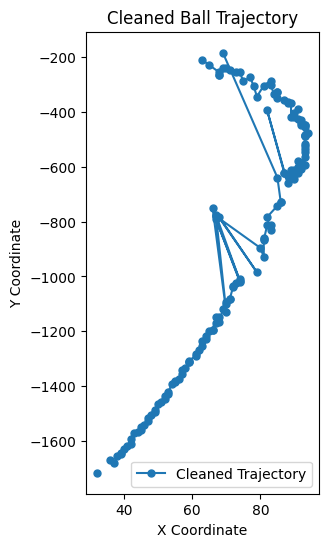

In [22]:
plot_trajectory(df_ball)

In [23]:
def remove_low_y_coordinates(df):
    # Copy to avoid modifying the original DataFrame
    df_cleaned = df.copy()

    # Convert 'y' to numeric in case it's not
    df_cleaned["y"] = pd.to_numeric(df_cleaned["y"], errors="coerce")

    # Mask condition: where y < -1750
    mask = (df_cleaned["y"] > 1750) | (df_cleaned["y"] < 0)

    # Set x and y to NaN where the mask is True
    df_cleaned.loc[mask, ["x", "y"]] = np.nan

    return df_cleaned

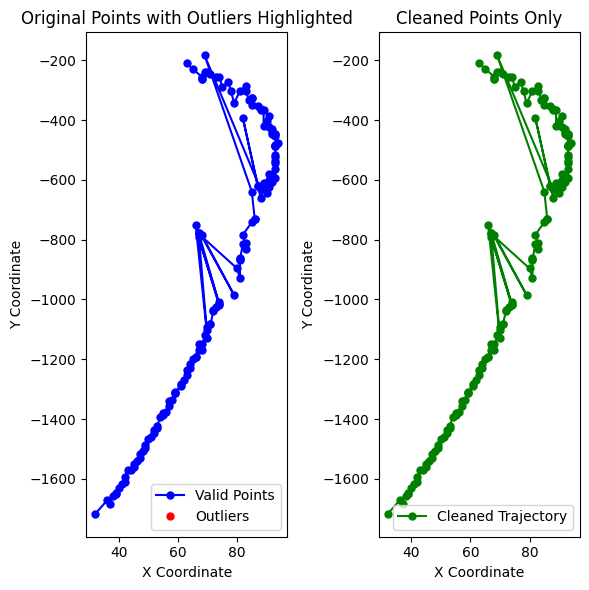

In [24]:
df_final = remove_low_y_coordinates(df_ball)
plot_comparison(df_ball, df_final)

Post-processing on the points removing the outliers

...

### Post-processing interpolation

In [25]:
def median_filter(df, kernel_size=3):
    df = df.copy()
    # Apply a median filter to smooth the coordinates (kernel size 5 by default)
    df["x"] = medfilt(df["x"], kernel_size=kernel_size)
    df["y"] = medfilt(df["y"], kernel_size=kernel_size)

    df = df[
        df["x"] > 0
    ]  # Because I had the problem witht he point 0,0 (I don't know why)
    df = df[df["y"] > 0]
    return df

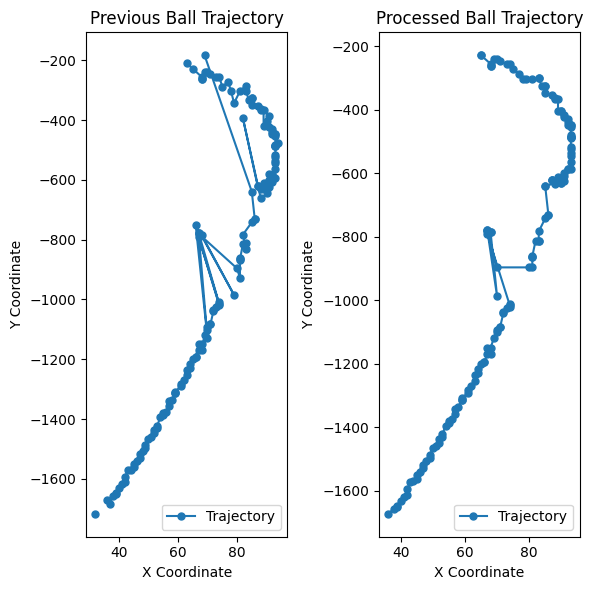

In [26]:
# Smooth the trajectory to reduce noise
df_smoothed = median_filter(df_final)

plot_trajectories(df_final, df_smoothed)

In [27]:
def Savitzky_Golay_filter(df, window_length=15, polyorder=1):
    df = df.copy()
    df["x"] = savgol_filter(df["x"], window_length=window_length, polyorder=polyorder)
    df["y"] = savgol_filter(df["y"], window_length=window_length, polyorder=polyorder)
    # Round the smoothed coordinates to integers
    df["x"] = df["x"].round().astype(int)
    df["y"] = df["y"].round().astype(int)

    return df

In [28]:
def interpolate_missing_coordinates(df):
    # Copy and set "frame" as the index
    df = df.copy().set_index("frame")

    # Create a new index that includes all frames from first to last
    full_index = range(df.index.min(), df.index.max() + 1)
    df_full = df.reindex(full_index)

    # Interpolate missing 'x' and 'y' coordinates (linear interpolation)
    df_full["x"] = df_full["x"].interpolate(method="linear")
    df_full["y"] = df_full["y"].interpolate(method="linear")

    # Fill any remaining NaN values using forward and backward filling
    df_full["x"] = df_full["x"].bfill().ffill()
    df_full["y"] = df_full["y"].bfill().ffill()

    # Reset index to bring the "frame" column back
    df_full = df_full.reset_index().rename(columns={"index": "frame"})

    # Apply smoothing to ensure a smooth trajectory
    df_full = Savitzky_Golay_filter(df_full)

    return df_full

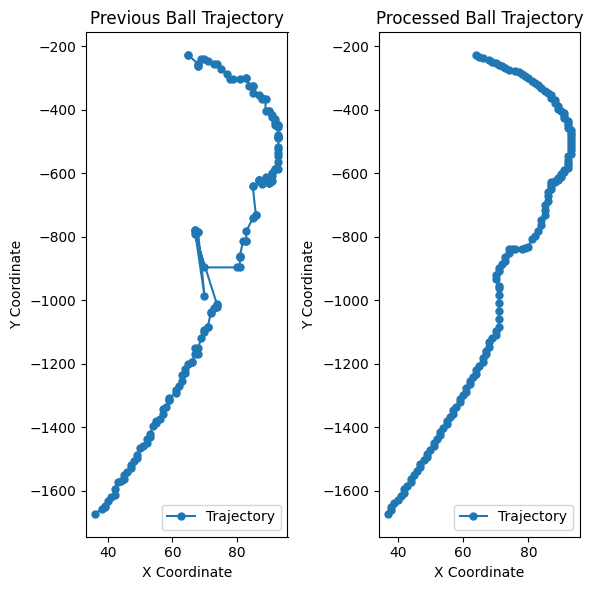

In [29]:
# Interpolate missing coordinates
df_interpolated = interpolate_missing_coordinates(df_smoothed)

# Now you can plot the result
plot_trajectories(df_smoothed, df_interpolated)

In [30]:
# Save the smoothed and interpolated data
# OUTPUT_CSV_PATH = str(PROJECT_ROOT / "data" / "auxiliary_data" / "circle_positions" / f"Circle_positions_processed_{VIDEO_NUMBER}.csv")
# df_interpolated.to_csv(OUTPUT_CSV_PATH, index=False)

# Save cleaned data
# OUTPUT_CSV_PATH = str(PROJECT_ROOT / "notebook" / "ball_detection" / "intermediate_data" / f"Circle_positions_cleaned_{VIDEO_NUMBER}.csv")
# df_cleaned.to_csv(OUTPUT_CSV_PATH, index=False)

TODO: start and finish detection when the ball enters and exits the track (required track detection). How to know when the ball is arrived at the end?

Do not do the interpolation with this data but with the data reconstructed on the lane reconstruction!!!